In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

import os

import random

from utils import *

In [3]:
# Need to run Preprocessing_1_Image.ipynb first before running this file
runs = pd.read_csv('data/image_csv_mapping.csv')
runs.head()

,RUN,IMAGE_ID,STEP1_MAG,STEP1C_RESULTS
0,Run15,data/extracted/Run15_0Hr_XY01_00001_CH4.png,data/zero_hour_csv/RUN_0015_STEP1_MAG.csv,data/zero_hour_csv/RUN_0015_STEP1C_Results.csv
1,Run15,data/extracted/Run15_0Hr_XY02_00001_CH4.png,data/zero_hour_csv/RUN_0015_STEP1_MAG.csv,data/zero_hour_csv/RUN_0015_STEP1C_Results.csv
2,Run15,data/extracted/Run15_0Hr_XY05_00001_CH4.png,data/zero_hour_csv/RUN_0015_STEP1_MAG.csv,data/zero_hour_csv/RUN_0015_STEP1C_Results.csv
3,Run15,data/extracted/Run15_0Hr_XY06_00001_CH4.png,data/zero_hour_csv/RUN_0015_STEP1_MAG.csv,data/zero_hour_csv/RUN_0015_STEP1C_Results.csv
4,Run15,data/extracted/Run15_0Hr_XY07_00001_CH4.png,data/zero_hour_csv/RUN_0015_STEP1_MAG.csv,data/zero_hour_csv/RUN_0015_STEP1C_Results.csv


### Combine STEP1_MAG and STEP1C_RESULTS file

#### MAG

In [4]:
missing_mag = []
step1mag = None

for i, file in enumerate(runs['STEP1_MAG'].unique()):
    
    try:
        temp = pd.read_csv(file)
    except:
        missing_mag.append(file)
        continue
        
    temp = temp[temp['EXPT_TIMEPOINT']=='0Hr']
    
    if i:
        step1mag = pd.concat([step1mag, temp], ignore_index=True)
    else:
        step1mag = temp
        
cols = ['IMAGE_ID', 'MEASURE_LABEL', 'MEASURE_VALUE1', 'OMIT_CALL', 'GROUP_DETAIL', 'GROUP_ID', 'MEASURE_T0_BASE_VALUE', 'MEASURE_MAG_VALUE']
mag = step1mag[cols]

In [5]:
cleaned_mag = None

for i, grp in mag.groupby('IMAGE_ID'):
    
    temp = {
        'IMAGE_ID':'data/extracted/' + i.replace('.tif', '.png'),
        'OMIT_CALL':grp['OMIT_CALL'].head(1).item(),
        'GROUP_ID':grp['GROUP_ID'].head(1).item(),
        'GROUP_DETAIL':grp['GROUP_DETAIL'].head(1).item(),
        'MEASURE_T0_BASE_VALUE':grp['MEASURE_T0_BASE_VALUE'].head(1).item(),
        'MEASURE_MAG_VALUE':grp['MEASURE_MAG_VALUE'].head(1).item(),
    }
    
    for label in grp['MEASURE_LABEL']:
        if 'Equation' not in label:
            temp[label] = grp[grp['MEASURE_LABEL']==label]['MEASURE_VALUE1'].item()
    
    temp = pd.DataFrame(temp, index=[0])
    
    if None:
        cleaned_mag = temp
    else:
        cleaned_mag = pd.concat([cleaned_mag, temp], ignore_index=False)
        
cleaned_mag = cleaned_mag[cleaned_mag['IMAGE_ID'].isin(runs['IMAGE_ID'])]
cleaned_mag.columns = cleaned_mag.columns.str.upper().str.replace(' ', '_', regex=False)
cleaned_mag.head()

,IMAGE_ID,OMIT_CALL,GROUP_ID,GROUP_DETAIL,MEASURE_T0_BASE_VALUE,MEASURE_MAG_VALUE,MENISCUS_LENGTH,EC50X,ESTIMATE_AUC,DONUT_AREA
0,data/extracted/Run31_0Hr_XY01_00001_CH4.png,KEEP,GRP1,Control,1.8924,0.0,1.8924,1.7594,1972747.967,NaN
0,data/extracted/Run31_0Hr_XY02_00001_CH4.png,KEEP,GRP1,Control,2.0520,0.0,2.0520,1.8737,1965624.399,NaN
0,data/extracted/Run31_0Hr_XY03_00001_CH4.png,KEEP,GRP1,Control,1.7784,0.0,1.7784,1.7339,1717204.275,NaN
0,data/extracted/Run31_0Hr_XY04_00001_CH4.png,KEEP,GRP1,Control,1.9152,0.0,1.9152,1.7677,1997997.683,NaN
0,data/extracted/Run31_0Hr_XY05_00001_CH4.png,OMIT,GRP1,Control,2.1660,0.0,2.1660,1.8894,2257338.205,NaN


#### STEP1C

In [6]:
step1c = None
missing_step1c = []

for i, file in enumerate(runs['STEP1C_RESULTS'].unique()):
    
    try:
        temp = pd.read_csv(file)
        
        if temp.columns[0] != 'EXPT_ID':
            temp = pd.read_csv(file, header=None)
            temp.columns = [
                'EXPT_ID', 'EXPT_DATE', 'PLATE_ID', 'EXPT_TIMEPOINT', 'WELL_ID',
               'IMAGE_ID', 'WELL_NUM', 'WELL_COL', 'WELL_ROW', 'MEASURE_LABEL',
               'MEASURE_VALUE1', 'MEASURE_VALUE2', 'MEASURE_UNIT', 'OMIT_CALL',
               'CIRCULARITY_VALUE', 'SUGGEST_OMIT'
            ]
    except:
        missing_step1c.append(file)
        continue
    
    temp = temp[temp['EXPT_TIMEPOINT']=='0Hr']
    
    if i:
        step1c = pd.concat([step1c, temp], ignore_index=True)
    else:
        step1c = temp
        
cols = ['IMAGE_ID', 'MEASURE_LABEL', 'MEASURE_VALUE1', 'OMIT_CALL', 'CIRCULARITY_VALUE', 'SUGGEST_OMIT']
results = step1c[cols]

In [7]:
cleaned_df = None

for i, grp in results.groupby('IMAGE_ID'):
    
    temp = {
        'IMAGE_ID':'data/extracted/' + i.replace('.tif', '.png'),
        'OMIT_CALL':grp['OMIT_CALL'].head(1).item(),
        'SUGGEST_OMIT':grp['SUGGEST_OMIT'].head(1).item(),
        'CIRCULARITY_VALUE':grp['CIRCULARITY_VALUE'].head(1).item(),
    }
    
    for label in grp['MEASURE_LABEL']:
        if 'Equation' not in label:
            temp[label] = grp[grp['MEASURE_LABEL']==label]['MEASURE_VALUE1'].item()
    
    temp = pd.DataFrame(temp, index=[0])
    
    if None:
        cleaned_df = temp
    else:
        cleaned_df = pd.concat([cleaned_df, temp], ignore_index=False)
        
cleaned_df = cleaned_df[cleaned_df['IMAGE_ID'].isin(runs['IMAGE_ID'])]
cleaned_df.columns = cleaned_df.columns.str.upper().str.replace(' ', '_', regex=False)
cleaned_df.head()

,IMAGE_ID,OMIT_CALL,SUGGEST_OMIT,CIRCULARITY_VALUE,REGRESSION_R2,MENISCUS_LENGTH,EC50X,EC50Y,ESTIMATE_AUC,DONUT_AREA
0,data/extracted/Run15_0Hr_XY01_00001_CH4.png,KEEP,Possible poor detection of inflection / menisc...,OK,0.999429,2.143200,1.7514,20343.270855,1463514.129569,NaN
0,data/extracted/Run15_0Hr_XY02_00001_CH4.png,KEEP,OK: fit 0.909665,OK,0.999262,2.371200,2.0167,32229.751964,2344710.040085,NaN
0,data/extracted/Run15_0Hr_XY05_00001_CH4.png,KEEP,OK: fit 0.935102,OK,0.999214,2.211600,1.8976,26054.752969,1737608.985110,NaN
0,data/extracted/Run15_0Hr_XY06_00001_CH4.png,KEEP,OK: fit 0.975717,OK,0.999291,2.029200,1.7781,20132.237483,1246844.341056,NaN
0,data/extracted/Run15_0Hr_XY07_00001_CH4.png,KEEP,OK: fit 0.240573,OK,0.998862,2.211600,1.7887,24441.022005,1782057.492993,NaN


#### MERGE TWO

Because results file is bigger, merge to that dataframe

In [8]:
cleaned_mag.head()

,IMAGE_ID,OMIT_CALL,GROUP_ID,GROUP_DETAIL,MEASURE_T0_BASE_VALUE,MEASURE_MAG_VALUE,MENISCUS_LENGTH,EC50X,ESTIMATE_AUC,DONUT_AREA
0,data/extracted/Run31_0Hr_XY01_00001_CH4.png,KEEP,GRP1,Control,1.8924,0.0,1.8924,1.7594,1972747.967,NaN
0,data/extracted/Run31_0Hr_XY02_00001_CH4.png,KEEP,GRP1,Control,2.0520,0.0,2.0520,1.8737,1965624.399,NaN
0,data/extracted/Run31_0Hr_XY03_00001_CH4.png,KEEP,GRP1,Control,1.7784,0.0,1.7784,1.7339,1717204.275,NaN
0,data/extracted/Run31_0Hr_XY04_00001_CH4.png,KEEP,GRP1,Control,1.9152,0.0,1.9152,1.7677,1997997.683,NaN
0,data/extracted/Run31_0Hr_XY05_00001_CH4.png,OMIT,GRP1,Control,2.1660,0.0,2.1660,1.8894,2257338.205,NaN


In [9]:
cleaned_df.head()

,IMAGE_ID,OMIT_CALL,SUGGEST_OMIT,CIRCULARITY_VALUE,REGRESSION_R2,MENISCUS_LENGTH,EC50X,EC50Y,ESTIMATE_AUC,DONUT_AREA
0,data/extracted/Run15_0Hr_XY01_00001_CH4.png,KEEP,Possible poor detection of inflection / menisc...,OK,0.999429,2.143200,1.7514,20343.270855,1463514.129569,NaN
0,data/extracted/Run15_0Hr_XY02_00001_CH4.png,KEEP,OK: fit 0.909665,OK,0.999262,2.371200,2.0167,32229.751964,2344710.040085,NaN
0,data/extracted/Run15_0Hr_XY05_00001_CH4.png,KEEP,OK: fit 0.935102,OK,0.999214,2.211600,1.8976,26054.752969,1737608.985110,NaN
0,data/extracted/Run15_0Hr_XY06_00001_CH4.png,KEEP,OK: fit 0.975717,OK,0.999291,2.029200,1.7781,20132.237483,1246844.341056,NaN
0,data/extracted/Run15_0Hr_XY07_00001_CH4.png,KEEP,OK: fit 0.240573,OK,0.998862,2.211600,1.7887,24441.022005,1782057.492993,NaN


**NOTES**

1. OMIT_CALL in STEP1C is not correct so use from MAG
2. If a column is shared, use the data from MAG

In [10]:
shared_columns = cleaned_df.columns[cleaned_df.columns.isin(cleaned_mag.columns)]

merged = cleaned_df.drop(columns=shared_columns.tolist()[1:]).merge(cleaned_mag, how='left', on='IMAGE_ID')

In [11]:
merged.head()

,IMAGE_ID,SUGGEST_OMIT,CIRCULARITY_VALUE,REGRESSION_R2,EC50Y,OMIT_CALL,GROUP_ID,GROUP_DETAIL,MEASURE_T0_BASE_VALUE,MEASURE_MAG_VALUE,MENISCUS_LENGTH,EC50X,ESTIMATE_AUC,DONUT_AREA
0,data/extracted/Run15_0Hr_XY01_00001_CH4.png,Possible poor detection of inflection / menisc...,OK,0.999429,20343.270855,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,data/extracted/Run15_0Hr_XY02_00001_CH4.png,OK: fit 0.909665,OK,0.999262,32229.751964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,data/extracted/Run15_0Hr_XY05_00001_CH4.png,OK: fit 0.935102,OK,0.999214,26054.752969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,data/extracted/Run15_0Hr_XY06_00001_CH4.png,OK: fit 0.975717,OK,0.999291,20132.237483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,data/extracted/Run15_0Hr_XY07_00001_CH4.png,OK: fit 0.240573,OK,0.998862,24441.022005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
merged.shape

(3411, 14)

In [16]:
temp = merged[(merged['OMIT_CALL']=='KEEP') | (merged['OMIT_CALL']=='OMIT')]

In [25]:
temp = temp[~temp['GROUP_DETAIL'].isin(['Control', 'Dry'])]

In [32]:
used_drugs = temp[temp['GROUP_DETAIL'].duplicated()]['GROUP_DETAIL'].unique()

In [38]:
for drug in ['100nM P4 1nM E2']:
    t = temp[temp['GROUP_DETAIL']==drug]
    
    break

In [39]:
t['OMIT_CALL'].value_counts()

KEEP    35
OMIT     3
Name: OMIT_CALL, dtype: int64

In [56]:
omits = t[t['OMIT_CALL']=='OMIT']['IMAGE_ID'].tolist()
keeps = t[t['OMIT_CALL']=='KEEP']['IMAGE_ID'][:3].tolist()

In [61]:
omits

['data/extracted/Run59_0Hr_XY61_00001_CH4.png',
 'data/extracted/Run61_0Hr_XY53_00001_CH4.png',
 'data/extracted/Run61_0Hr_XY86_00001_CH4.png']

In [88]:
# fig, ax = plt.subplots(3,2, figsize=(12, 20), sharey=True, sharex=True)

# for i in range(3):
    
#     row, col = i//2, i%2

#     omit = omits[i].replace('data/extracted/', '').replace('.png', '')
#     keep = keeps[i].replace('data/extracted/', '').replace('.png', '')
    
#     ax[i][0].imshow(plt.imread(omits[i]), cmap='gray')
#     ax[i][0].set_title(omit)
#     ax[i][0].set_xlabel('OMIT', size=14)
    
#     ax[i][1].imshow(plt.imread(keeps[i]), cmap='gray')
#     ax[i][1].set_title(omit)
#     ax[i][1].set_xlabel('KEEP', size=14)

# plt.tight_layout()
# plt.show();

Because we need correlation columns to OMIT_CALL, convert it so that KEEP=1, OMIT=0. If null, -1

In [13]:
merged.loc[merged['OMIT_CALL']=='KEEP', 'OMIT_CALL'] = 1
merged.loc[merged['OMIT_CALL']=='OMIT', 'OMIT_CALL'] = 0
merged['OMIT_CALL'].fillna(-1, inplace=True)
merged['OMIT_CALL'] = merged['OMIT_CALL'].astype(int)

Looks like if there is a drug, it's listed first then followed by its name. Only the value `Control` and `Dry` do not have amount as they are single value

In [14]:
merged['GROUP_DETAIL'].fillna('NA', inplace=True)

In [15]:
merged['GROUP_DETAIL'].value_counts()

NA                     799
Control                605
Dry                    477
10uM Inh172            237
20uM Inh172            199
40uM Inh172            174
10nM E2                119
1uM GlyH101             75
100nM E2                75
1nM E2                  70
5uM GlyH101             67
100uM Bumetanide        63
400uM Bumetanide        59
5uM Inh172              53
100nM P4 1nM E2         38
300mM Mannitol          30
100mM Mannitol          29
1uM Inh172              26
1uM P4                  18
Control 10nM E2         17
8uL PBS                 17
2uL PBS                 16
1 uM P4 1nM E2          15
10nM E2 Dry             13
6uL PBS                 13
4uL PBS                 13
200uM Bumetanide        13
100nM P4                13
10uM GlyH101            12
10nM P4                 12
40uM GlyH101            11
Control Dry             10
Dry Control 10nM E2      8
Dry 100nM P4 1nM E2      8
10nM P4 1nM E2           7
Name: GROUP_DETAIL, dtype: int64

In [16]:
merged['DRY'] = 0
merged['CONTROL'] = 0

merged.loc[merged['GROUP_DETAIL'].str.contains('Dry'), 'DRUG_DRY'] = 1
merged.loc[merged['GROUP_DETAIL'].str.contains('Control'), 'DRUG_CONTROL'] = 1
merged.loc[merged['GROUP_DETAIL']=='NA', 'DRUG_MISSING'] = 1

merged['GROUP_DETAIL'] = merged['GROUP_DETAIL'].str.replace('Dry', '', regex=False)\
                                                .str.replace('Control', '', regex=False)\
                                                .str.replace('NA', '', regex=False)

merged['GROUP_DETAIL'] = merged['GROUP_DETAIL'].str.strip()
merged.reset_index(drop=True, inplace=True)

In [17]:
merged['GROUP_DETAIL'].value_counts()

                    1891
10uM Inh172          237
20uM Inh172          199
40uM Inh172          174
10nM E2              157
1uM GlyH101           75
100nM E2              75
1nM E2                70
5uM GlyH101           67
100uM Bumetanide      63
400uM Bumetanide      59
5uM Inh172            53
100nM P4 1nM E2       46
300mM Mannitol        30
100mM Mannitol        29
1uM Inh172            26
1uM P4                18
8uL PBS               17
2uL PBS               16
1 uM P4 1nM E2        15
6uL PBS               13
4uL PBS               13
200uM Bumetanide      13
100nM P4              13
10uM GlyH101          12
10nM P4               12
40uM GlyH101          11
10nM P4 1nM E2         7
Name: GROUP_DETAIL, dtype: int64

Some drug amount is separated by space. Ex) 1 uM

In [18]:
sizes = ['nM', 'uM', 'mM', 'uL']

for size in sizes:
    merged['GROUP_DETAIL'] = merged['GROUP_DETAIL'].str.replace(' {}'.format(size), size, regex=False)

In [19]:
merged['GROUP_DETAIL'].value_counts()

                    1891
10uM Inh172          237
20uM Inh172          199
40uM Inh172          174
10nM E2              157
1uM GlyH101           75
100nM E2              75
1nM E2                70
5uM GlyH101           67
100uM Bumetanide      63
400uM Bumetanide      59
5uM Inh172            53
100nM P4 1nM E2       46
300mM Mannitol        30
100mM Mannitol        29
1uM Inh172            26
1uM P4                18
8uL PBS               17
2uL PBS               16
1uM P4 1nM E2         15
6uL PBS               13
4uL PBS               13
200uM Bumetanide      13
100nM P4              13
10uM GlyH101          12
10nM P4               12
40uM GlyH101          11
10nM P4 1nM E2         7
Name: GROUP_DETAIL, dtype: int64

In [20]:
drugs_found = []

for d in merged['GROUP_DETAIL'].unique():
    if d == '' or d == 'NA':
        continue
    drugs = d.split(' ')
    drugs = [drug for i, drug in enumerate(drugs) if i%2==1]
    drugs_found.extend(drugs)
    
drugs_found = [x.upper() for x in set(drugs_found)]
drugs_found.sort()

print(drugs_found)

['BUMETANIDE', 'E2', 'GLYH101', 'INH172', 'MANNITOL', 'P4', 'PBS']


In [21]:
for drug in drugs_found:
    merged['DRUG_{}'.format(drug)] = 0
    
for i, record in merged.iterrows():
    
    drugs = record['GROUP_DETAIL'].split(' ')
    
    if len(drugs) < 2:
        continue
        
    for i in range(0, len(drugs), 2):
        amount = drugs[i]
        drug = drugs[i+1]
        
        merged.loc[i, 'DRUG_{}'.format(drug.upper())] = amount
        
merged.drop(columns=['GROUP_DETAIL'], inplace=True)

In [22]:
for c in merged.columns:
    try:
        merged[c] = pd.to_numeric(merged[c])
    except:
        pass

In [23]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3411 entries, 0 to 3410
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   IMAGE_ID               3411 non-null   object 
 1   SUGGEST_OMIT           1555 non-null   object 
 2   CIRCULARITY_VALUE      3411 non-null   object 
 3   REGRESSION_R2          3411 non-null   float64
 4   EC50Y                  3411 non-null   float64
 5   OMIT_CALL              3411 non-null   int64  
 6   GROUP_ID               2612 non-null   object 
 7   MEASURE_T0_BASE_VALUE  2612 non-null   float64
 8   MEASURE_MAG_VALUE      2612 non-null   float64
 9   MENISCUS_LENGTH        2612 non-null   float64
 10  EC50X                  2612 non-null   float64
 11  ESTIMATE_AUC           2612 non-null   float64
 12  DONUT_AREA             1728 non-null   float64
 13  DRY                    3411 non-null   int64  
 14  CONTROL                3411 non-null   int64  
 15  DRUG

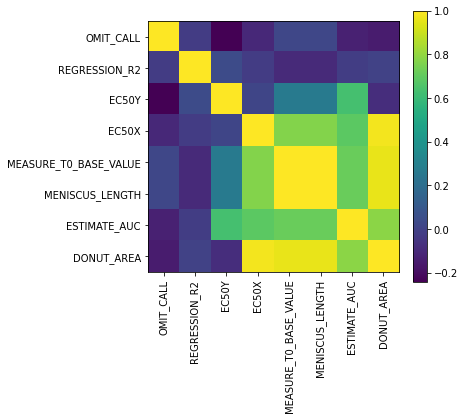

In [24]:
num_cols = [	
    'OMIT_CALL',
    'REGRESSION_R2',
    'EC50Y',
    'EC50X',
    'MEASURE_T0_BASE_VALUE',
    'MENISCUS_LENGTH',
    'ESTIMATE_AUC',
    'DONUT_AREA',
   ]

corr = merged[num_cols].corr(method='pearson')
fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(corr, interpolation='nearest')
ax.set_xticks(list(range(len(num_cols))), num_cols, rotation=90)
ax.set_yticks(list(range(len(num_cols))), num_cols)
fig.colorbar(im, orientation='vertical', fraction = 0.05);

In [25]:
corr

,OMIT_CALL,REGRESSION_R2,EC50Y,EC50X,MEASURE_T0_BASE_VALUE,MENISCUS_LENGTH,ESTIMATE_AUC,DONUT_AREA
OMIT_CALL,1.000000,-0.021281,-0.244018,-0.099213,0.020445,0.020445,-0.128247,-0.149944
REGRESSION_R2,-0.021281,1.000000,0.039050,-0.023145,-0.098049,-0.098049,-0.017227,0.002457
EC50Y,-0.244018,0.039050,1.000000,0.017486,0.266299,0.266299,0.633457,-0.078927
EC50X,-0.099213,-0.023145,0.017486,1.000000,0.768789,0.768789,0.687305,0.977542
MEASURE_T0_BASE_VALUE,0.020445,-0.098049,0.266299,0.768789,1.000000,1.000000,0.715568,0.960641
MENISCUS_LENGTH,0.020445,-0.098049,0.266299,0.768789,1.000000,1.000000,0.715568,0.960641
ESTIMATE_AUC,-0.128247,-0.017227,0.633457,0.687305,0.715568,0.715568,1.000000,0.781767
DONUT_AREA,-0.149944,0.002457,-0.078927,0.977542,0.960641,0.960641,0.781767,1.000000


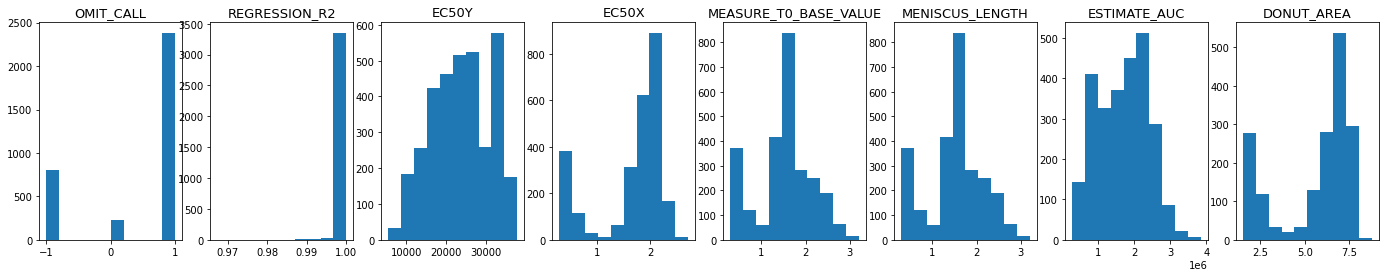

In [26]:
fig, ax = plt.subplots(1, len(num_cols), figsize=(24, 4))

for i, c in enumerate(num_cols):
    ax[i].hist(merged[c])
    ax[i].set_title(c, fontsize=13)

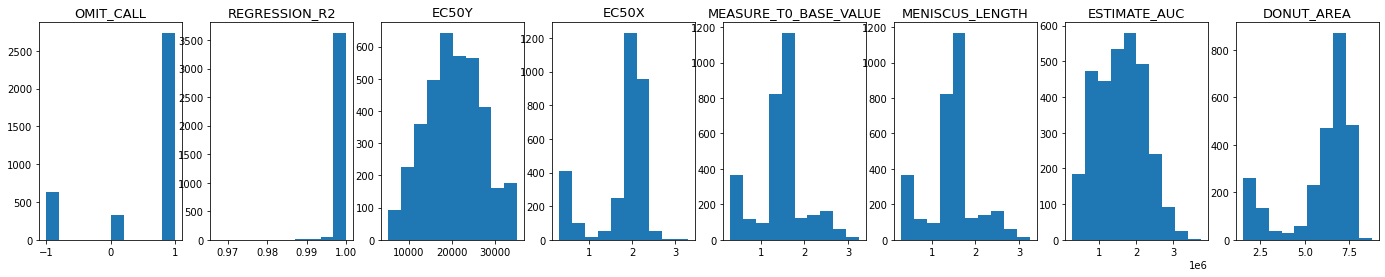Normalize all? Maybe only for EC50Y since it's too big but other features seem like they are within certain range.

Findings to report/ask

1. Notify Dr. Leo and Mackenzie that STEP1C's OMIT_CALL differs from STEP1_MAG's OMIT_CALL even with the same IMAGE_ID which suggests that the one in 1C is an accident
2. Will each drug have specific range of amount it can take? for example, can Drug A be used for 10nM and sometimes 10uM?

In [27]:
merged.head()

,IMAGE_ID,SUGGEST_OMIT,CIRCULARITY_VALUE,REGRESSION_R2,EC50Y,OMIT_CALL,GROUP_ID,MEASURE_T0_BASE_VALUE,MEASURE_MAG_VALUE,MENISCUS_LENGTH,...,DRUG_DRY,DRUG_CONTROL,DRUG_MISSING,DRUG_BUMETANIDE,DRUG_E2,DRUG_GLYH101,DRUG_INH172,DRUG_MANNITOL,DRUG_P4,DRUG_PBS
0,data/extracted/Run15_0Hr_XY01_00001_CH4.png,Possible poor detection of inflection / menisc...,OK,0.999429,20343.270855,-1,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,400uM,100nM,1uM,10uM,300mM,1uM,8uL
1,data/extracted/Run15_0Hr_XY02_00001_CH4.png,OK: fit 0.909665,OK,0.999262,32229.751964,-1,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,0,0,0,0,0,0,0
2,data/extracted/Run15_0Hr_XY05_00001_CH4.png,OK: fit 0.935102,OK,0.999214,26054.752969,-1,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,0,1nM,0,0,0,0,0
3,data/extracted/Run15_0Hr_XY06_00001_CH4.png,OK: fit 0.975717,OK,0.999291,20132.237483,-1,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,0,0,0,0,0,0,0
4,data/extracted/Run15_0Hr_XY07_00001_CH4.png,OK: fit 0.240573,OK,0.998862,24441.022005,-1,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,0,0,0,0,0,0,0


In [28]:
merged.shape

(3411, 25)

In [29]:
merged.to_csv('data/merged.csv', index=False)

THINGS THAT CAN BE ADDED

1. RUN_0047_STEP2_MAG_GRP.csv
2. RUN_0047_STEP2_SLIM_TTEST_MAG.csv

These two have some columns that's already been gathered like drugs information, only other metadata need to be merged, if used